In [ ]:
#This is the code for WS2 defect polarisation measurements

In [1]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
%matplotlib inline
import nplab.datafile as df
import scipy.signal as sig
import scipy.constants as const
import peakutils
import numpy as np
import datetime
from peakutils.plot import plot as pplot
from parula import cm_data
from matplotlib.colors import LinearSegmentedColormap 
from matplotlib.collections import LineCollection
import os
import Alexsdatafuncs
import matplotlib.cm as cm
import time
import scipy.integrate as integrate
import scipy.special as special

In [2]:
parula_map = LinearSegmentedColormap.from_list('parula', cm_data)
copper_map = LinearSegmentedColormap.from_list('copper', cm_data)
colours_1 = cm.viridis(np.linspace(0,1,500))
colours_2 = cm.hot(np.linspace(0,1,500))
Alex_data = Alexsdatafuncs.data_manipulators()
Alex_plot = Alexsdatafuncs.plotting_funcs()

In [272]:
df.close_current()

In [3]:
data_f = df.open_file(set_current = False)
fname = data_f.filename

C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/CVD WS2 grown on Au/Polarisation dependence/2019-04-26_271118_WS2_polmeas.h5


In [25]:
test = data_f.show_gui()

Running GUI, this will block the command line until the window is closed.


In [6]:
opt_meas_1 = data_f['OceanOpticsSpectrometer']

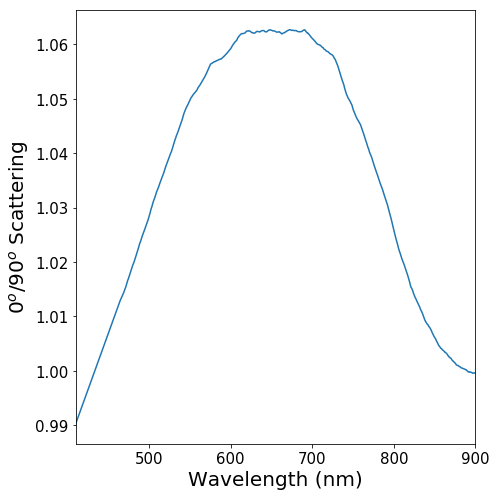

In [12]:
#Scattering enhancement due to polariser
Angle_0_enha = (opt_meas_1["Reference_pol2_0_1"].value)/(opt_meas_1["Reference_pol2_90_1"].value)
start_wl = 410 #Wavelength range to use - normalisation can be ruined by noise
fin_wl = 900
start_ind = (np.abs(wl - start_wl)).argmin()
fin_ind = (np.abs(wl - fin_wl)).argmin()

Angle_0_en_sm = sig.savgol_filter(Angle_0_enha,173,1)
Angle_0_en_sm = Angle_0_en_sm[start_ind:fin_ind]

fig = plt.figure(1, figsize = (7,7))
ax = fig.add_subplot(111)
ax.plot(wl_r,Angle_0_en_sm)
ax.set_xlim(410, 900)
ax.set_ylabel("$0^o$/$90^o$ Scattering", fontsize = 20)
ax.set_xlabel("Wavelength (nm)", fontsize = 20)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)

fig.savefig('C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/CVD WS2 grown on Au/Polarisation dependence/Raw_pol_scattering_ratio.png', bbox_inches='tight')


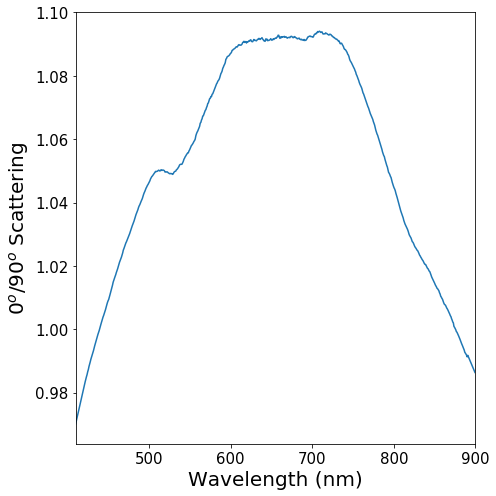

In [13]:
#Now need to correct for the Au background change
#There is an increase in scattering at 0 degrees compared to 90 degrees for scattering from a white light scatter
# This is non-plasmonic scattering which is happening anyway. 
# On the other hand there is a decrease in scattering at 0 degrees compared to 90 degrees on Au. 

BG_0 = opt_meas_1["BG_pol2_0_0"].value
BG_0 = BG_0[start_ind:fin_ind]
BG_90 = opt_meas_1["BG_pol2_90_0"].value
BG_90_c = BG_90[start_ind:fin_ind]*Angle_0_en_sm

BG_90_c = sig.savgol_filter(BG_90_c,173,1)
BG_0 = sig.savgol_filter(BG_0,23,1)

BG_ref = BG_90_c/BG_0

fig = plt.figure(1, figsize = (7,7))
ax = fig.add_subplot(111)
#ax.plot(wl_r,BG_90_c)
ax.plot(wl_r,BG_ref)
ax.set_xlim(410, 900)
ax.set_ylabel("$0^o$/$90^o$ Scattering", fontsize = 20)
ax.set_xlabel("Wavelength (nm)", fontsize = 20)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)

fig.savefig('C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/CVD WS2 grown on Au/Polarisation dependence/Raw_pol_scattering_ratio_Au.png', bbox_inches='tight')


In [26]:
#Sort and filter all data according to their timestamp and restrict wavelength range

start_time_tot = datetime.datetime.strptime('2019-04-26T15:20:13.091000', 
                                        "%Y-%m-%dT%H:%M:%S.%f")
finish_time_tot = datetime.datetime.strptime('2019-04-26T15:41:04.157000', 
                                        "%Y-%m-%dT%H:%M:%S.%f")

df_ref = opt_meas_1.values()[0].attrs['reference']
df_bgd = opt_meas_1.values()[0].attrs['background']
wl = opt_meas_1.values()[0].attrs['wavelengths']

#Create array to hold data with corresponding time value
all_data_w_time = []
all_data_w_time_n = []

#Iterate through data set and make array with data in one column and timestamp in the other
for data_set in opt_meas_1.values():
    
    t = datetime.datetime.strptime(
                        data_set.attrs['creation_timestamp'][:19], "%Y-%m-%dT%H:%M:%S")
    
    n = data_set.name[25:]
    
                     
    data = (data_set.value - df_bgd)/(df_ref-df_bgd)
    
    if t >= start_time_tot and t <= finish_time_tot: #Make sure you choose the right start and finish time

        s = (t-datetime.datetime(1970,1,1)).total_seconds()

        data_w_time = np.append(data, s)
        all_data_w_time.append(data_w_time)
    
#Sort all the data vs timestamp   
all_data_w_time_sorted = sorted(all_data_w_time,key=lambda x: x[-1])
all_data = np.delete(all_data_w_time_sorted, -1,1) #Delete the timestamp column of data

#Filter the data to help define peaks
all_data_filtered = []
for i in range(0, len(all_data)):
    filt_data = sig.savgol_filter(all_data[i],23,3)
    all_data_filtered.append(filt_data)

In [27]:

start_wl = 410 #Wavelength range to use - normalisation can be ruined by noise
fin_wl = 900
start_ind = (np.abs(wl - start_wl)).argmin()
fin_ind = (np.abs(wl - fin_wl)).argmin()
norm_data = []

#for i in range(len(PLonAu)):
#    PLonAu[i] = PLonAu[i]*(df_ref-df_bgd)

all_data_cr = []
for i in range(len(all_data)):
    all_data_i = all_data[i][start_ind:fin_ind]
    all_data_cr.append(all_data_i)
    
all_data_norm = []
for i in range(len(all_data)):
    inf_norm = np.linalg.norm(all_data_cr[i], axis=0, ord = np.inf)
    all_data_norm.append(all_data_cr[i]/inf_norm)

wl_r = wl[start_ind:fin_ind]

Text(0,0.5,u'Spectrum number')

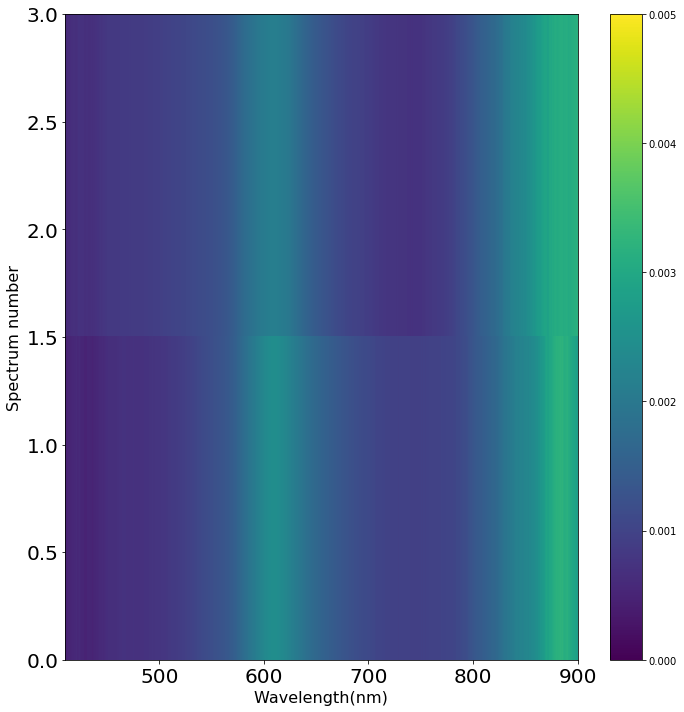

In [28]:
fig1 = plt.figure(1, figsize = (10, 10))
ax1 = fig1.add_subplot(111)

#all_sorted_array = np.array(sorted_array, dtype=float)

all_data_cr_sm = []
for i in range(0, len(all_data_cr)):
    filt_data = sig.savgol_filter(all_data_cr[i],23,1)
    all_data_cr_sm.append(filt_data)  

mapfig1 = ax1.imshow(all_data_cr_sm[:-1][::-1], 
                    extent=[start_wl, fin_wl,
                    0, len(all_data_cr_sm)], aspect = 'auto', 
                            cmap = cm.viridis, vmin = [0, 0.005])

fig1.colorbar(mapfig1)

ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)
ax1.set_xlabel("Wavelength(nm)", fontsize = 16)
ax1.set_ylabel("Spectrum number", fontsize = 16)

#fig1.savefig('C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/CVD WS2 grown on Au/Polarisation dependence/Defect13_90steps_map.png', bbox_inches='tight')
  

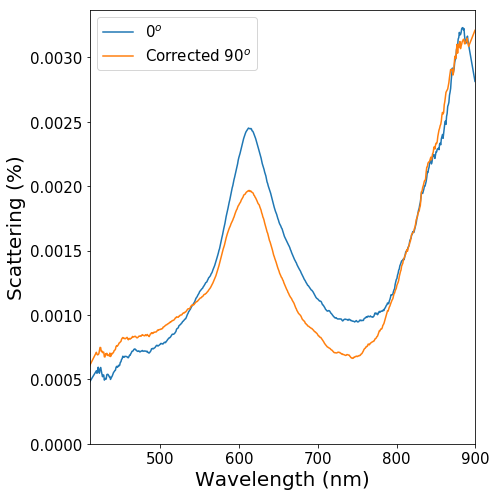

In [29]:
#Plot the raw data
fig = plt.figure(1, figsize = (7,7))
ax = fig.add_subplot(111)

#for i in range (0, len(all_data_cr_sm)-1):
#    ax.plot(wl_r, all_data_cr_sm[i])

ax.plot(wl_r, all_data_cr_sm[0], label = "$0^o$")
#ax.plot(wl_r, all_data_cr_sm[1], label = "$90^o$")
ax.plot(wl_r, all_data_cr_sm[1]/BG_ref, label = "Corrected $90^o$")
#ax.plot(wl_r, all_data_cr_sm[0]/all_data_cr_sm[1], label = "$ratio$")


ax.set_xlim(start_wl, fin_wl)

ax.set_ylabel("Scattering (%)", fontsize = 20)
ax.set_xlabel("Wavelength (nm)",fontsize = 20)
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.legend(fontsize = 15)
ax.set_ylim(0,)

    
fig.savefig('C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/CVD WS2 grown on Au/Polarisation dependence/Defect6_90steps_plot.png', bbox_inches='tight')
